In [1]:
import sys
sys.path.append(r'../')
import os
os.chdir('../')
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from functions import Database, preprocess_data, prep_data, BunDLeNet, train_model, plotting_neuronal_behavioural, plot_latent_timeseries, plot_phase_space, rotating_plot

%reload_ext autoreload
%autoreload 2

2025-01-29 13:58:57.294241: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 13:58:57.295316: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 13:58:57.316325: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 13:58:57.317003: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-29 13:58:57.727380: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

## Load Data (excluding behavioural neurons)

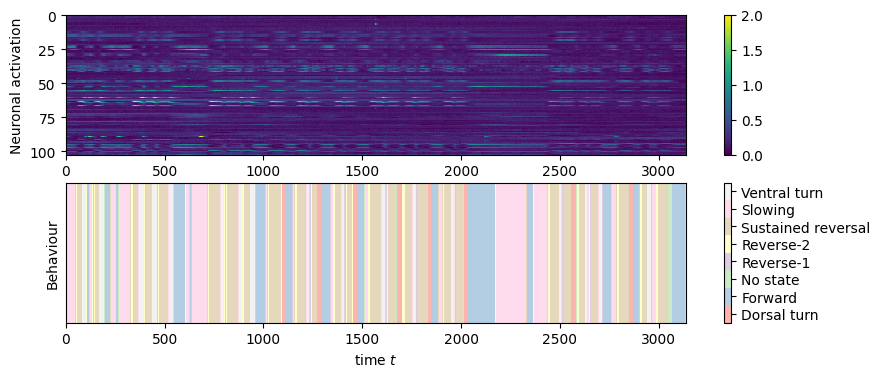

In [5]:
worm_num = 0
b_neurons = [
	'AVAR',
	'AVAL',
	'SMDVR',
	'SMDVL',
	'SMDDR',
	'SMDDL',
	'RIBR',
	'RIBL'
]
data = Database(data_set_no=worm_num)
data.exclude_neurons(b_neurons)
X = data.neuron_traces.T

B = data.states
state_names = ['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reversal', 'Slowing', 'Ventral turn']
plotting_neuronal_behavioural(X, B, state_names=state_names)

## Preprocess data and embed with BunDLe-Net

In [20]:
### Preprocess and prepare data for BundLe Net
time, X = preprocess_data(X, data.fps)
X_, B_ = prep_data(X, B, win=15)

### Deploy BunDLe Net
model = BunDLeNet(latent_dim=3)
model.build(input_shape=X_.shape)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

loss_array = train_model(
	X_,
	B_,
	model,
	optimizer,
	gamma=0.9, 
	n_epochs=2000,
	pca_init=False,
	best_of_5_init=False
)

Losses 0.005519 0.003635 0.009155: 100%|██████████| 2000/2000 [01:35<00:00, 20.96it/s]


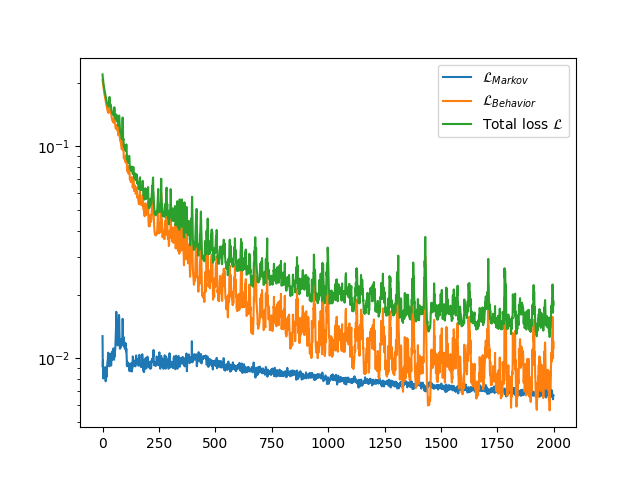

In [22]:
# Training losses vs epochs
plt.figure()
for i, label in  enumerate(["$\mathcal{L}_{{Markov}}$", "$\mathcal{L}_{{Behavior}}$","Total loss $\mathcal{L}$" ]):
	plt.semilogy(loss_array[:,i], label=label)
plt.legend()
plt.show()

## Projecting into latent space

In [23]:
Y0_ = model.tau(X_[:,0]).numpy() # X_[:, 0] extracts the first time step for each window. Y0_ is the latent representation of all the steps

In [ ]:
# trial = model.tau(X_[:10,0]).numpy()

# plot_phase_space(trial, B_[:10], state_names = state_names)

In [ ]:
# print(X_[:,0].shape)

# single_window = X_[0, 0]  # Shape: (15, 103)
# single_window_flattened = single_window.flatten()  # Shape: (15*103 = 1545,)

# # Ensure the tensor has the correct dtype (float32)
# single_window_flattened = tf.convert_to_tensor(single_window_flattened, dtype=tf.float32)
# dimension = X_[0, 0].shape[0] * X_[0, 0].shape[1]

# # Pass through the model
# single_window_transformed = model.tau(tf.reshape(single_window_flattened, (1, dimension)))  # Add batch dimension
# print(single_window_transformed.numpy())  # Output the transformed latent representation




In [ ]:
# # Example sequence (time_series_length = 100, num_features = 103)
# sequence = np.random.rand(100, 103)  # Shape: (100, 103)

# sequence_, Bseq_ = prep_data(sequence, B[:sequence.shape[0]], win=15)
# print(sequence_.shape)

In [21]:
# Y0_sequence_ = model.tau(sequence_[:,0]).numpy()
# plot_phase_space(Y0_sequence_, Bseq_, state_names = state_names)

## Visualising embedding

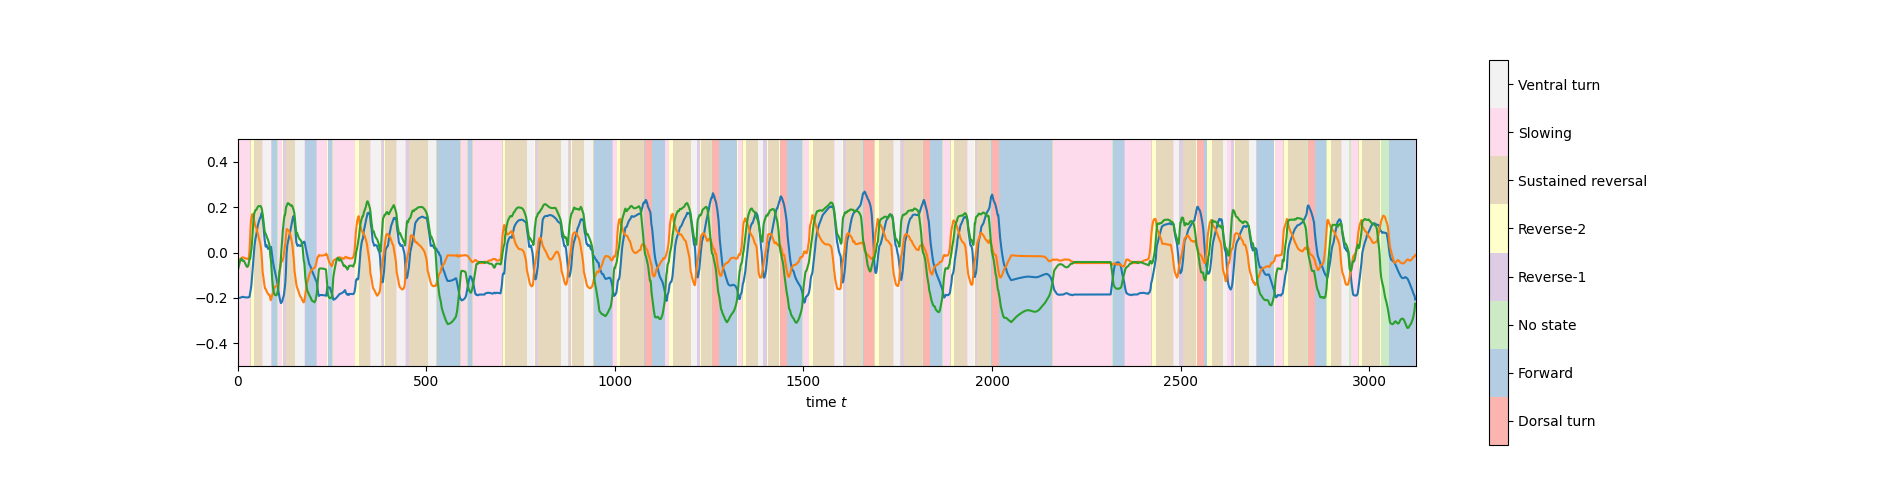

In [24]:
plot_latent_timeseries(Y0_, B_, state_names)

/home/dariosannino/BunDLe-Net/functions.py:549: RuntimeWarning: divide by zero encountered in divide
  color=colors[B[i]], arrow_length_ratio=0.1/np.linalg.norm(d), linewidths=1, **kwargs)
/home/dariosannino/BunDLe-Net/.venv/lib/python3.10/site-packages/mpl_toolkits/mplot3d/axes3d.py:2718: RuntimeWarning: invalid value encountered in multiply
  arrow_dt = shaft_dt * arrow_length_ratio
/home/dariosannino/BunDLe-Net/.venv/lib/python3.10/site-packages/mpl_toolkits/mplot3d/axes3d.py:2741: RuntimeWarning: invalid value encountered in multiply
  heads = shafts[:, :1] - np.multiply.outer(arrow_dt, head_dirs)


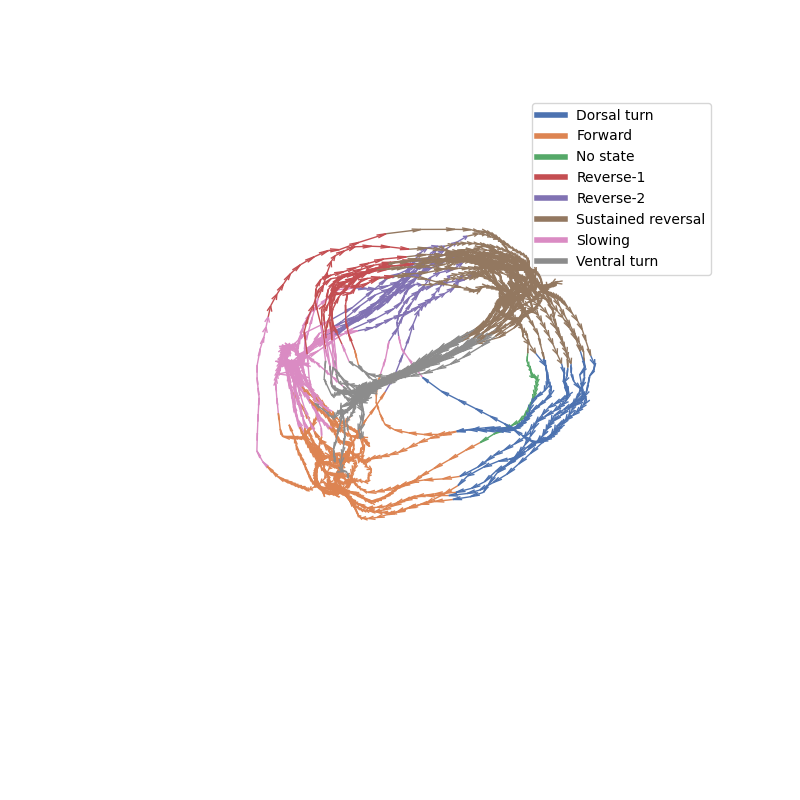

(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [25]:
%matplotlib widget

plot_phase_space(Y0_, B_, state_names = state_names)

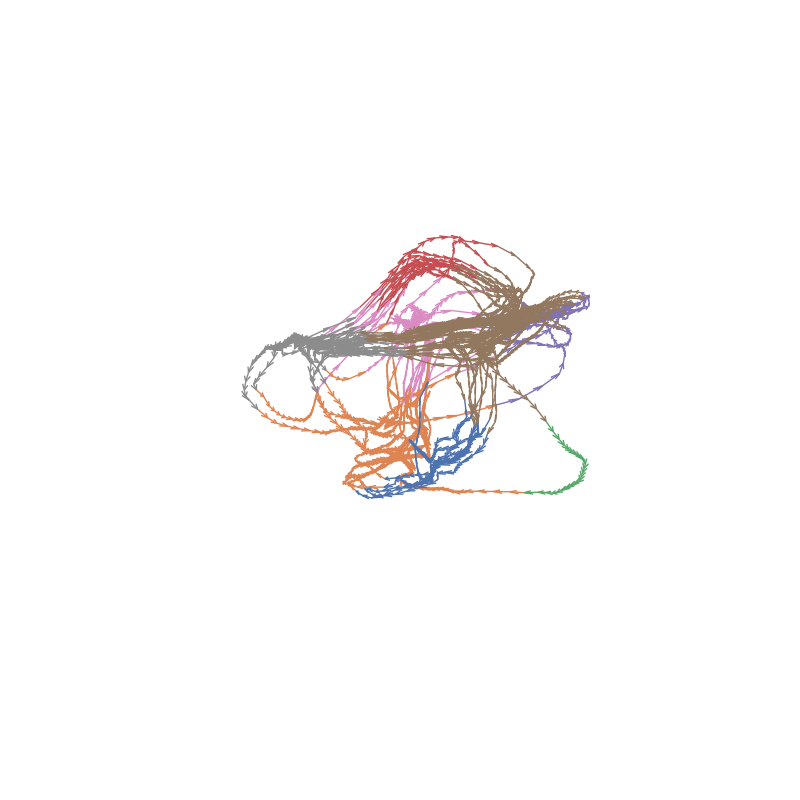

<Axes3D: >

In [26]:
### Run to produce rotating 3-D plot
%matplotlib widget
algorithm = 'trial'

rotating_plot(Y0_, B_,filename='figures/rotation_'+ algorithm + '_worm_'+str(worm_num) +'.gif', state_names=state_names, legend=False)

### Performing PCA on the latent dimension (to check if there are redundant or correlated components)


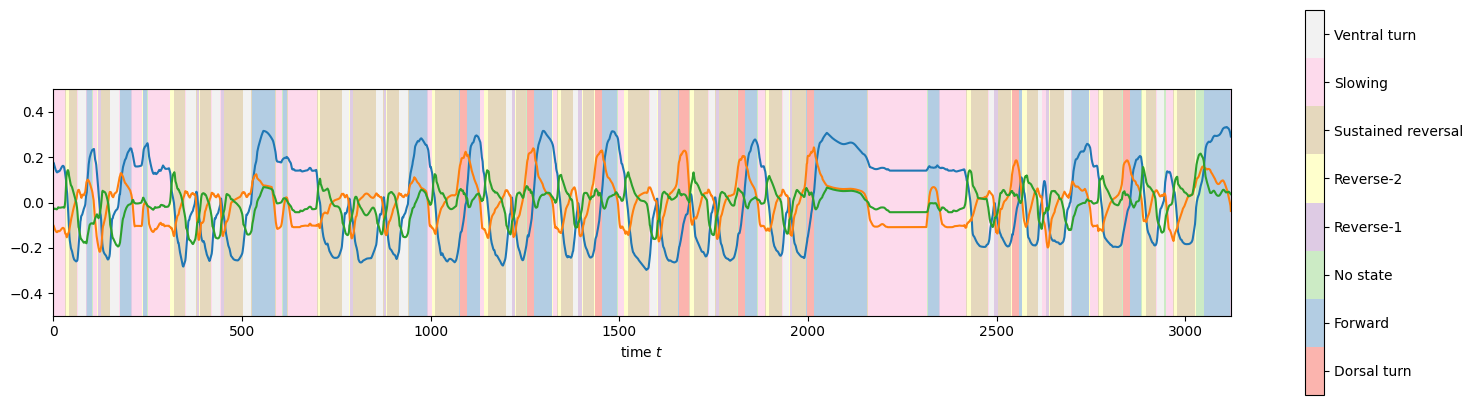

In [28]:
%matplotlib inline
pca = PCA()
Y_pca = pca.fit_transform(Y0_)
plot_latent_timeseries(Y_pca, B_, state_names)


### Recurrence plot analysis of BunDLeNet's embedding

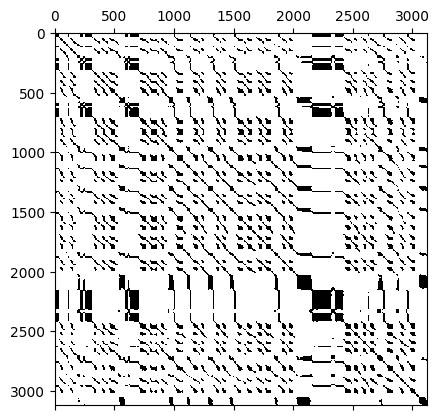

In [29]:
pd_Y = np.linalg.norm(Y0_[:, np.newaxis] - Y0_, axis=-1) < 0.8
plt.matshow(pd_Y, cmap='Greys')
plt.show()

Let's try now to see how the manifold looks like with a lower amount of neurons selected

Number of selected neurons 22
Selected neurons:
 ['OLQVL' 'OLQDL' 'RMEL' 'RMER' 'SMDVR' 'AVAL' 'AVAR' 'SMDVL' 'ASKR' 'ASKL'
 '51' 'AIBR' 'RIVR' 'RIMR' 'RIVL' 'RIML' 'SMDDR' 'RIFR' 'VB01' '103'
 'DB02' 'DB01']




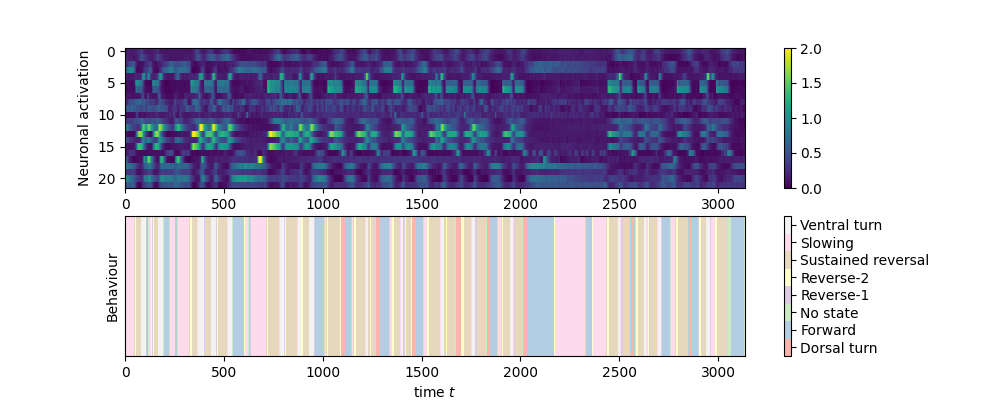

In [18]:
data2 = Database(data_set_no=worm_num)
X2 = data2.neuron_traces.T
derivatives = data2.derivative_traces.T

peak_magnitudes = np.max(X2, axis=0) # Find peak magnitudes for each neuron
normalized_derivs = derivatives / peak_magnitudes  # Normalize derivatives
variances = np.var(normalized_derivs, axis=0)
threshold = np.percentile(variances, 80)  # Take all the neurons whose variance is above the threshold. The selected neurons could be different from the one selected by the normal traces
deriv_selected_neurons = variances > threshold

print(f'Number of selected neurons {deriv_selected_neurons.sum()}')  # Print the number of neurons that remain after variance reduction
print(f'Selected neurons:\n {data2.neuron_names[deriv_selected_neurons]}')
print('\n')

plotting_neuronal_behavioural(X2[:, deriv_selected_neurons], B, state_names=state_names)

In [19]:
### Preprocess and prepare data for BundLe Net
time, X2 = preprocess_data(X2[:, deriv_selected_neurons], data2.fps)
X2_, B_ = prep_data(X2, B, win=15)

### Deploy BunDLe Net
model = BunDLeNet(latent_dim=3)
model.build(input_shape=X2_.shape)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

loss_array = train_model(
	X2_,
	B_,
	model,
	optimizer,
	gamma=0.9, 
	n_epochs=2000,
	pca_init=False,
	best_of_5_init=False
)

Losses 0.006003 0.004660 0.010663: 100%|██████████| 2000/2000 [01:06<00:00, 30.03it/s]


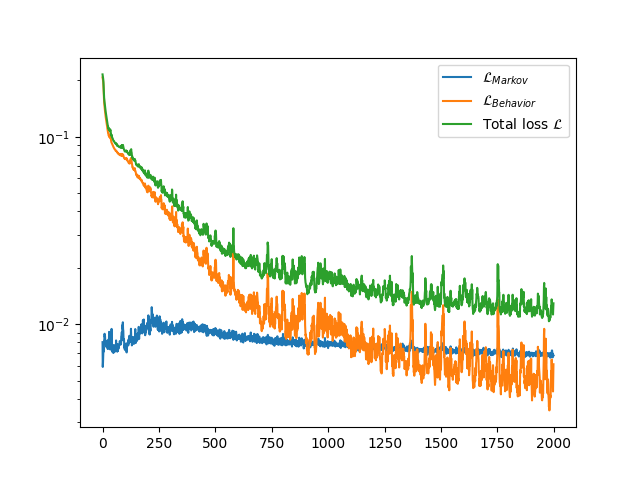

In [20]:
# Training losses vs epochs
plt.figure()
for i, label in  enumerate(["$\mathcal{L}_{{Markov}}$", "$\mathcal{L}_{{Behavior}}$","Total loss $\mathcal{L}$" ]):
	plt.semilogy(loss_array[:,i], label=label)
plt.legend()
plt.show()

In [21]:
Y02_ = model.tau(X2_[:,0]).numpy() # X_[:, 0] extracts the first time step for each window. Y0_ is the latent representation of all the steps

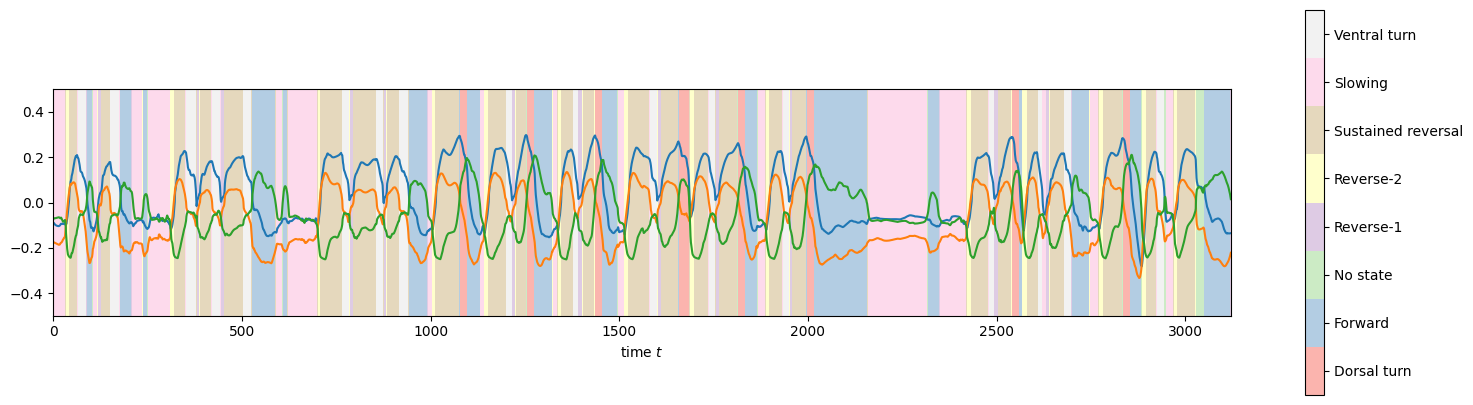

In [33]:
plot_latent_timeseries(Y02_, B_, state_names)

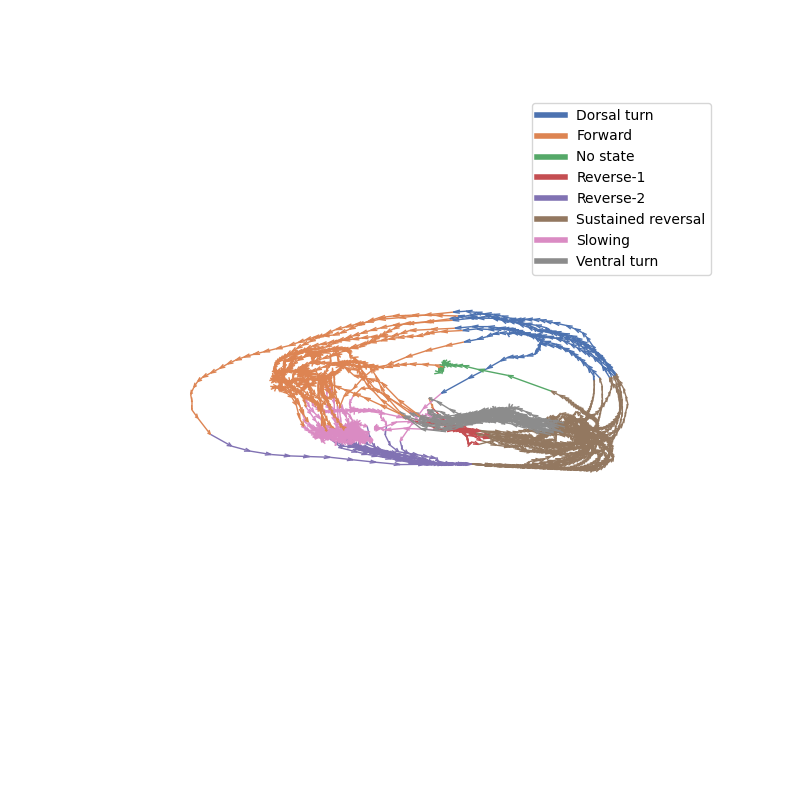

(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [24]:
%matplotlib widget

plot_phase_space(Y02_, B_, state_names = state_names)

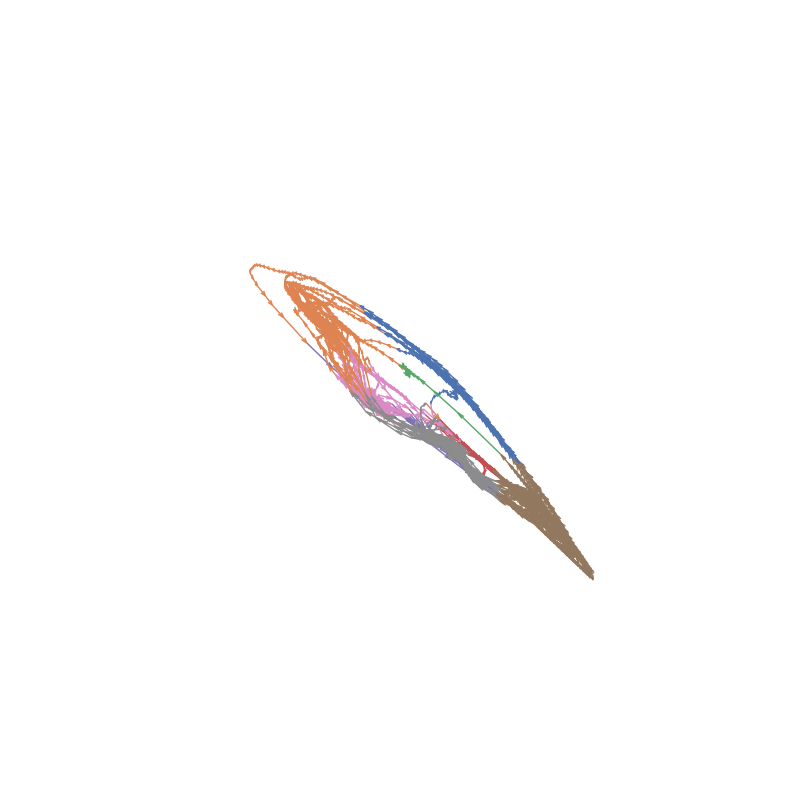

<Axes3D: >

No such comm: fcc1c1a2e33c44f88a76b15ef2a5c982


In [25]:
### Run to produce rotating 3-D plot
%matplotlib widget
algorithm = 'trial'

rotating_plot(Y02_, B_,filename='figures/rotation_'+ algorithm + '_worm_'+str(worm_num) +'.gif', state_names=state_names, legend=False)

In [26]:
import pickle

# Load the file
with open("generated_traces.pkl", "rb") as file:  # "rb" means read in binary mode
    generated_traces = pickle.load(file)

print(type(generated_traces))  # show that you have a dict

print(generated_traces[1450].shape)  # select the number of the epoch that you prefer. You will get a shape of (time-steps, neurons)

<class 'dict'>
(609, 22)


In [27]:
# Example sequence (time_series_length = 609, num_features = 22)

sequence_, Bseq_ = prep_data(generated_traces[1450], B[-generated_traces[1450].shape[0]:], win=15)
print(sequence_.shape)

(594, 2, 15, 22)


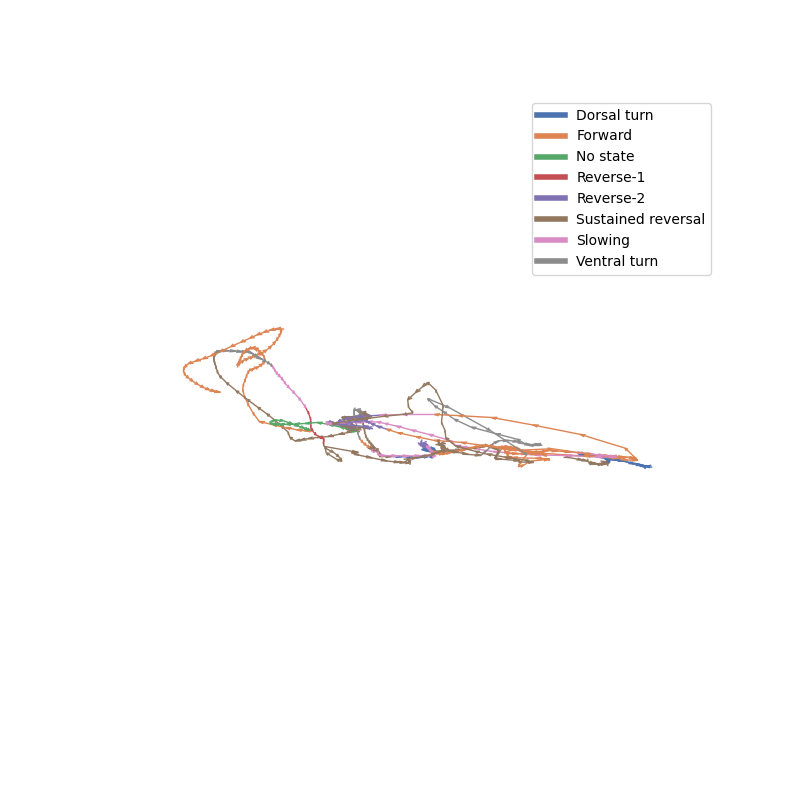

(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [28]:
Y0_sequence_ = model.tau(sequence_[:,0]).numpy()
plot_phase_space(Y0_sequence_, Bseq_, state_names = state_names)

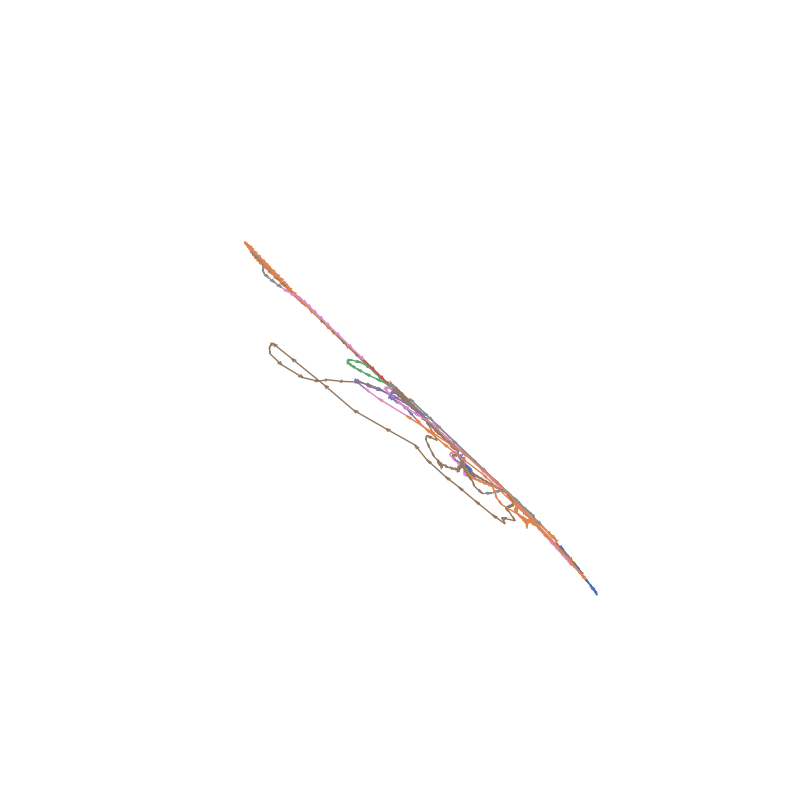

<Axes3D: >

In [29]:
### Run to produce rotating 3-D plot
%matplotlib widget
algorithm = 'trial'

rotating_plot(Y0_sequence_, Bseq_,filename='figures/rotation_'+ algorithm + '_worm_'+str(worm_num) +'.gif', state_names=state_names, legend=False)